# Quantitative Analysis of Zone-entries-exits-prediction model

This notebook performs the quantitative evaluation of the trained neural network model (`NN_En_Ex.h5`) using the held-out test dataset.  
In addition, it loads the **scaler** and the **zone categories mapping** from the training phase in `B_NN Development` to correctly interpret the features. 

**Inputs:**  
- `NN_En_Ex.h5` (trained model)  
- `test_set.npz` (test data)  
- `num_scaler.pkl` (fitted MinMax scaler for time features)  
- `zone_categories.npy` (mapping of encoded zone identifiers to category labels)  

**Outputs:**  
- Relative error metrics (**Mean Percentage Error – MPE**)  
- Analysis of performance by dimensions (day of week, time window, zone)  
- Intersectional error heatmaps for spatio-temporal performance patterns  

The results generated here provide the quantitative evidence reported in the corresponding model cards, available at:  
[Mobility Model Cards – Zone Entries/Exits Prediction](https://github.com/emeralds-horizon/EMERALDS_Mobility_Model_Cards_on_Zone_Entries_Exits_Prediction/tree/main)



### Load Model, Test Data, and Preprocessing Objects

In [12]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import joblib

#load model
model = tf.keras.models.load_model("NN_En_Ex.h5")

#load test set
data = np.load("test_set.npz")
X_test_num = data["X_num"]
X_test_em  = data["X_em"]
y_test     = data["y"]

scaler = joblib.load("num_scaler.pkl")
zone_categories = np.load("zone_categories.npy", allow_pickle=True)

### Model Predictions

In [13]:
y_pred = model.predict([X_test_num, X_test_em])
df_y_pred = pd.DataFrame(y_pred, columns=["y_pred_entries","y_pred_exits"])

331/331 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [14]:

# --- Inverse-transform numeric features (to human-readable values) ---
X_test_num_unscaled = scaler.inverse_transform(X_test_num)
df_num = pd.DataFrame(X_test_num_unscaled, columns=['datetime_day_week','datetime_W'])

# --- Zones ---
df_em = pd.DataFrame(X_test_em, columns=['zone_codes'])
df_em["zone_label"] = df_em["zone_codes"].map(dict(enumerate(zone_categories)))

# --- Targets ---
df_y_test = pd.DataFrame(y_test, columns=["y_true_entries","y_true_exits"])
df_y_pred = pd.DataFrame(y_pred, columns=["y_pred_entries","y_pred_exits"])

# --- Combine all ---
df_all = pd.concat([df_num, df_em, df_y_test, df_y_pred], axis=1)


### Quantitative Analysis:

#### Unitary results:
To examine how the model performs across different aspects of the mobility data, errors are computed separately by:
- **Day of the Week**
- **Time Window**
- **Zone**  

This breakdown highlights whether prediction quality is affected more by temporal patterns (e.g. weekdays vs weekends, peak vs off-peak hours) or by spatial variation across zones.


In [15]:
import numpy as np
import pandas as pd

# --- Safe mean percentage error (avoids div/0) ---
def safe_mpe(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mask = y_true != 0  # ignore zero true values
    if mask.sum() == 0:
        return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# --- Generic evaluator ---
def evaluate_multidim_outputs_by_group(df, group_col, y_true_cols, y_pred_cols, metric_func):
    results = []
    for group, group_df in df.groupby(group_col):
        entry_score = metric_func(group_df[y_true_cols[0]], group_df[y_pred_cols[0]])
        exit_score  = metric_func(group_df[y_true_cols[1]], group_df[y_pred_cols[1]])
        results.append({
            group_col: group,
            f'{y_true_cols[0]}_score': entry_score,
            f'{y_true_cols[1]}_score': exit_score
        })
    return pd.DataFrame(results)

# --- Apply for your three main dimensions ---
mpe_by_day_week = evaluate_multidim_outputs_by_group(
    df_all, group_col='datetime_day_week',
    y_true_cols=['y_true_entries', 'y_true_exits'],
    y_pred_cols=['y_pred_entries', 'y_pred_exits'],
    metric_func=safe_mpe
)

mpe_by_datetime_W = evaluate_multidim_outputs_by_group(
    df_all, group_col='datetime_W',
    y_true_cols=['y_true_entries', 'y_true_exits'],
    y_pred_cols=['y_pred_entries', 'y_pred_exits'],
    metric_func=safe_mpe
)

mpe_by_zone_codes = evaluate_multidim_outputs_by_group(
    df_all, group_col='zone_codes',
    y_true_cols=['y_true_entries', 'y_true_exits'],
    y_pred_cols=['y_pred_entries', 'y_pred_exits'],
    metric_func=safe_mpe
)

# --- Quick preview ---
print("MPE by Day of Week:\n", mpe_by_day_week.head())
print("MPE by Time Window:\n", mpe_by_datetime_W.head())
print("MPE by Zone:\n", mpe_by_zone_codes.head())


MPE by Day of Week:
    datetime_day_week  y_true_entries_score  y_true_exits_score
0                1.0             50.605114           46.560959
1                2.0             47.590958           47.360573
2                3.0             46.927681           47.438148
3                4.0             46.253914           47.014648
4                5.0             47.023144           46.576099
MPE by Time Window:
    datetime_W  y_true_entries_score  y_true_exits_score
0        10.0             47.559620          167.381119
1        13.0             79.266426           77.388336
2        14.0             79.068565           68.468964
3        15.0             53.494190           59.391529
4        16.0            110.306801          105.504951
MPE by Zone:
    zone_codes  y_true_entries_score  y_true_exits_score
0           0             59.518589           56.898624
1           1             77.199051           77.757774
2           2             39.816010           38.580257
3     

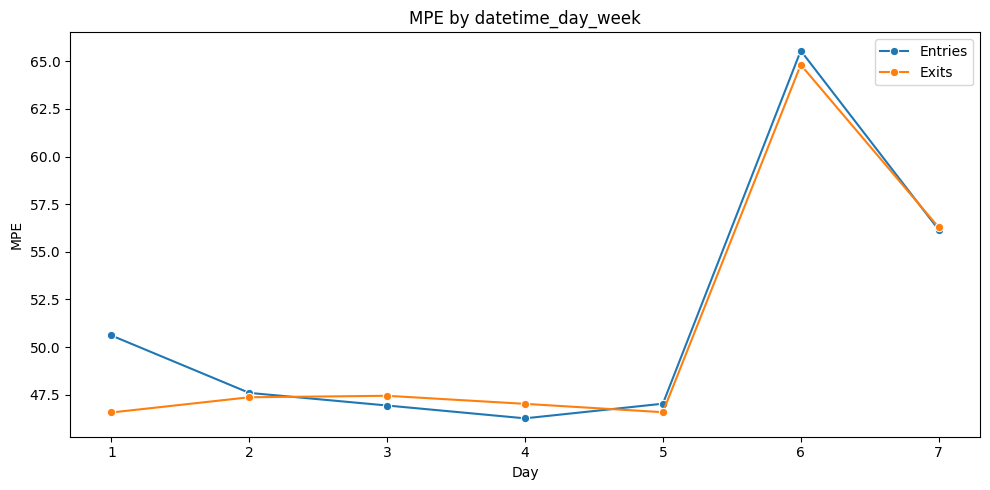

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.lineplot(data=mpe_by_day_week, x='datetime_day_week', y='y_true_entries_score', label='Entries', marker='o')
sns.lineplot(data=mpe_by_day_week, x='datetime_day_week', y='y_true_exits_score', label='Exits', marker='o')
plt.title('MPE by datetime_day_week')
plt.xlabel('Day')
plt.ylabel('MPE')
plt.legend()
plt.tight_layout()
plt.show()


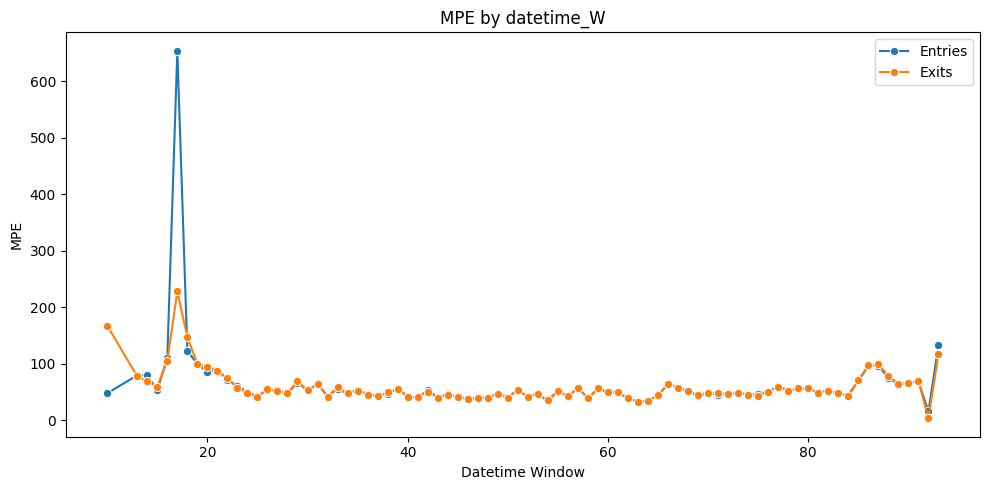

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.lineplot(data=mpe_by_datetime_W, x='datetime_W', y='y_true_entries_score', label='Entries', marker='o')
sns.lineplot(data=mpe_by_datetime_W, x='datetime_W', y='y_true_exits_score', label='Exits', marker='o')
plt.title('MPE by datetime_W')
plt.xlabel('Datetime Window')
plt.ylabel('MPE')
plt.legend()
plt.tight_layout()
plt.show()


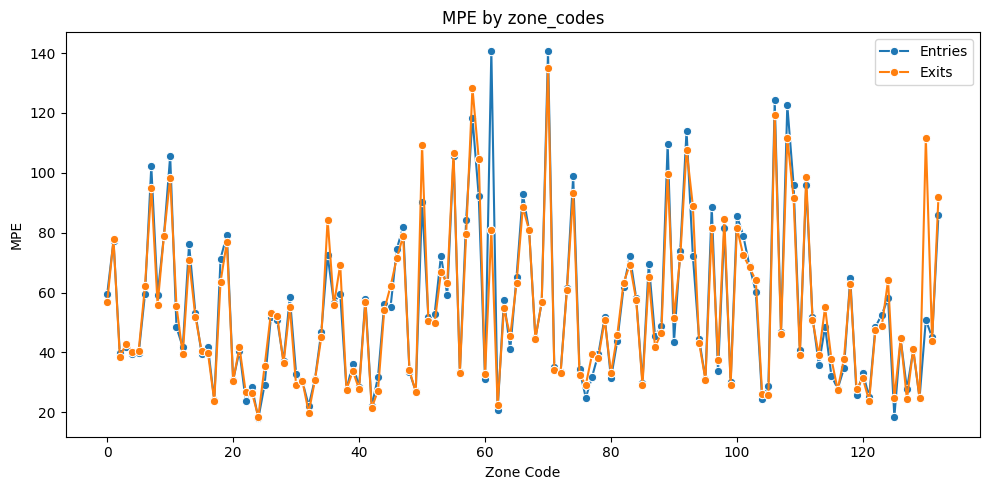

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.lineplot(data=mpe_by_zone_codes, x='zone_codes', y='y_true_entries_score', label='Entries', marker='o')
sns.lineplot(data=mpe_by_zone_codes, x='zone_codes', y='y_true_exits_score', label='Exits', marker='o')
plt.title('MPE by zone_codes')
plt.xlabel('Zone Code')
plt.ylabel('MPE')
plt.legend()
plt.tight_layout()
plt.show()


#### Intersectional result
Errors are also analysed across combinations of dimensions to identify spatio-temporal patterns in prediction performance. The following heatmaps visualise the Mean Percentage Error (MPE) for intersections:  
- **Zone × Day of the Week**  
- **Zone × Time Window**  
- **Day of the Week × Time Window**  

These visualisations make it possible to detect systematic biases, such as higher error in certain zones during weekday peak hours.


In [19]:
# Helper function (already fixed for multiple group columns)

def evaluate_multidim_outputs_by_group(df, group_col, y_true_cols, y_pred_cols, metric_func):
    results = []
    for group, group_df in df.groupby(group_col):
        entry_score = metric_func(group_df[y_true_cols[0]], group_df[y_pred_cols[0]])
        exit_score  = metric_func(group_df[y_true_cols[1]], group_df[y_pred_cols[1]])
        
        # Handle single vs multiple grouping columns
        if isinstance(group, tuple):
            group_dict = {col: val for col, val in zip(group_col, group)}
        else:
            group_dict = {group_col: group}
        
        group_dict.update({
            f"{y_true_cols[0]}_score": entry_score,
            f"{y_true_cols[1]}_score": exit_score
        })
        results.append(group_dict)
    return pd.DataFrame(results)

# 1. Zone × Day of Week
mpe_by_zone_day = evaluate_multidim_outputs_by_group(
    df_all,
    group_col=['zone_codes','datetime_day_week'],
    y_true_cols=['y_true_entries','y_true_exits'],
    y_pred_cols=['y_pred_entries','y_pred_exits'],
    metric_func=safe_mpe
)

# 2. Zone × Time Window
mpe_by_zone_time = evaluate_multidim_outputs_by_group(
    df_all,
    group_col=['zone_codes','datetime_W'],
    y_true_cols=['y_true_entries','y_true_exits'],
    y_pred_cols=['y_pred_entries','y_pred_exits'],
    metric_func=safe_mpe
)

# 3. Day of Week × Time Window
mpe_by_day_time = evaluate_multidim_outputs_by_group(
    df_all,
    group_col=['datetime_day_week','datetime_W'],
    y_true_cols=['y_true_entries','y_true_exits'],
    y_pred_cols=['y_pred_entries','y_pred_exits'],
    metric_func=safe_mpe
)

In [20]:
# Ensure day-of-week is integer [0–6]
mpe_by_zone_day["datetime_day_week"] = mpe_by_zone_day["datetime_day_week"].round().astype(int)
mpe_by_day_time["datetime_day_week"] = mpe_by_day_time["datetime_day_week"].round().astype(int)

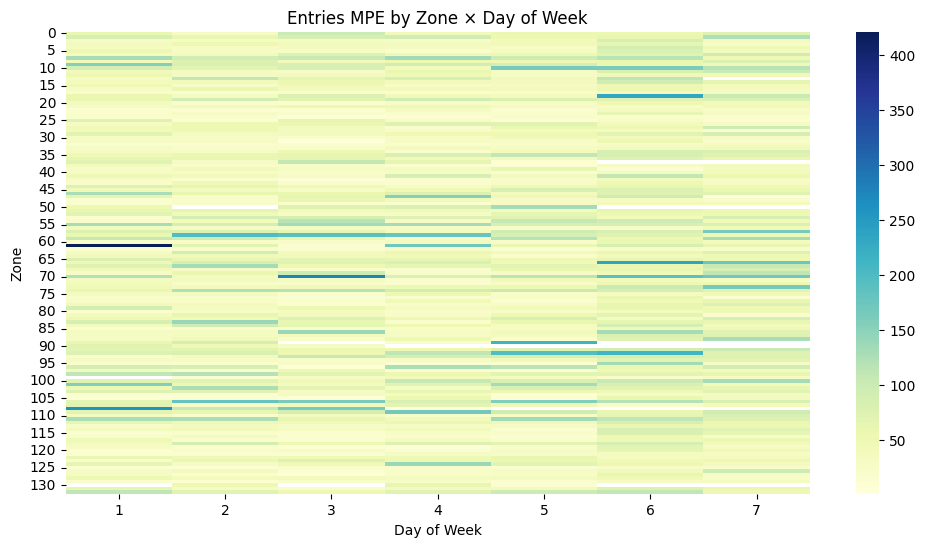

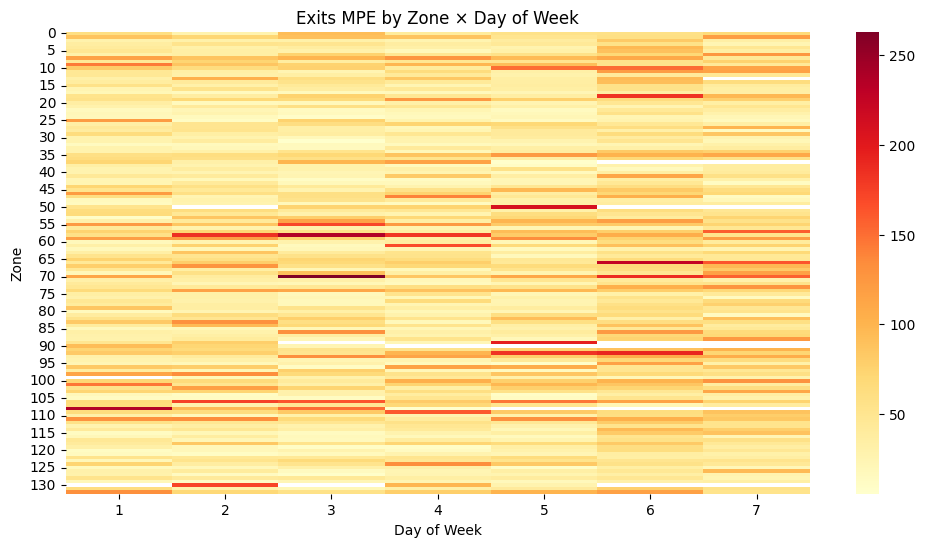

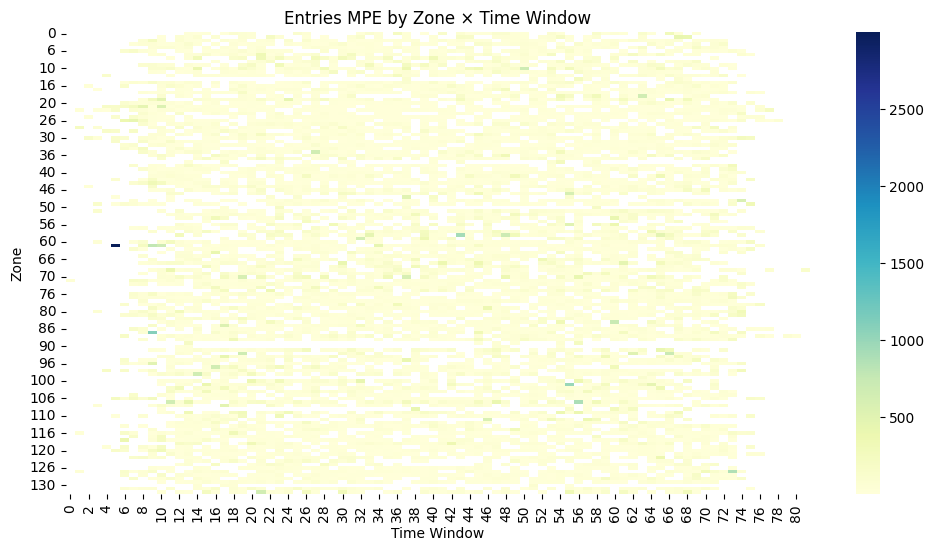

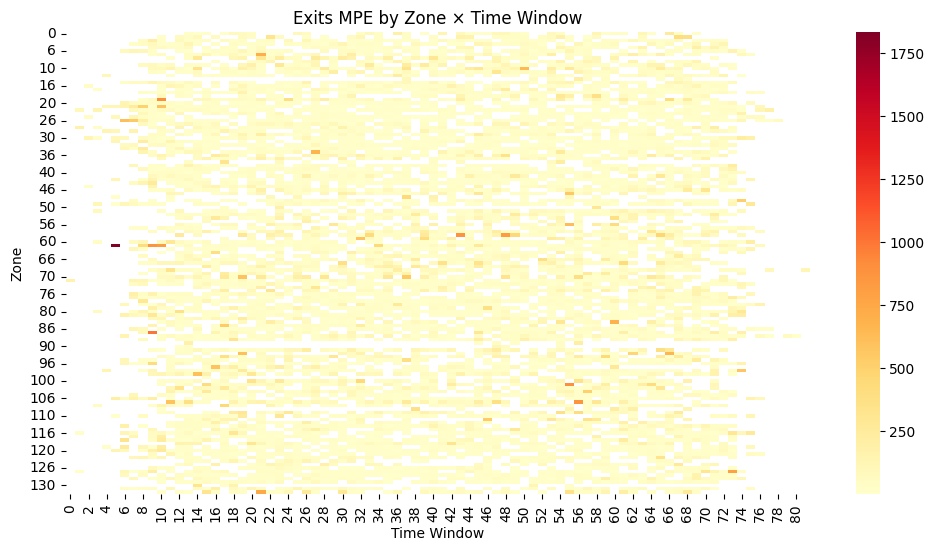

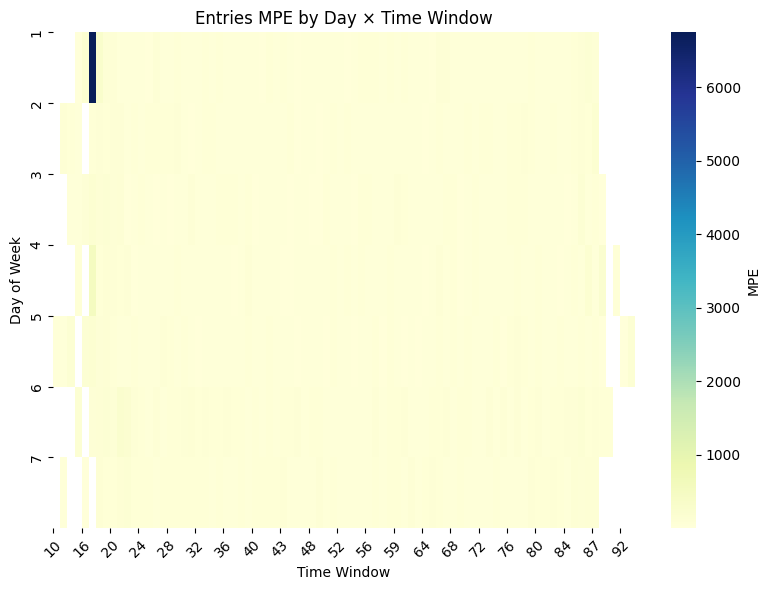

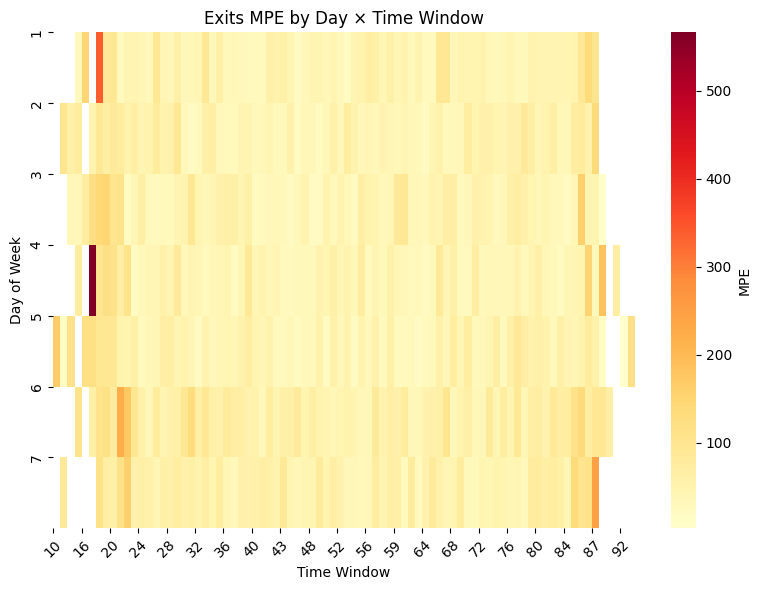

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Zone × Day
# pivot_zone_day_entries = mpe_by_zone_day.pivot(index="zone_codes", columns="datetime_day_week", values="y_true_entries_score")
pivot_zone_day_entries = mpe_by_zone_day.pivot_table(
    index="zone_codes",
    columns="datetime_day_week",
    values="y_true_entries_score",
    aggfunc="mean"   # or "median"
)

pivot_zone_day_exits = mpe_by_zone_day.pivot_table(
    index="zone_codes",
    columns="datetime_day_week",
    values="y_true_exits_score",
    aggfunc="mean"
)
def format_axis_ticks(ax, decimals=0):
    """Round tick labels on both axes"""
    ax.set_xticklabels([f"{tick:.{decimals}f}" if isinstance(tick, (int,float)) else tick for tick in ax.get_xticks()])
    ax.set_yticklabels([f"{tick:.{decimals}f}" if isinstance(tick, (int,float)) else tick for tick in ax.get_yticks()])

# Example: Zone × Day (Entries)
plt.figure(figsize=(12, 6))
ax = sns.heatmap(pivot_zone_day_entries, cmap="YlGnBu", annot=False)
plt.title("Entries MPE by Zone × Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Zone")
# format_axis_ticks(ax, decimals=0)   # round to integers
plt.show()

plt.figure(figsize=(12, 6))
ax = sns.heatmap(pivot_zone_day_exits, cmap="YlOrRd", annot=False)
plt.title("Exits MPE by Zone × Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Zone")
# format_axis_ticks(ax, decimals=0)   # round to integers
plt.show()


# 2. Zone × Time Window
pivot_zone_time_entries = mpe_by_zone_time.pivot(index="zone_codes", columns="datetime_W", values="y_true_entries_score")
pivot_zone_time_exits   = mpe_by_zone_time.pivot(index="zone_codes", columns="datetime_W", values="y_true_exits_score")

plt.figure(figsize=(12, 6))
ax = sns.heatmap(pivot_zone_time_entries, cmap="YlGnBu", annot=False)
plt.title("Entries MPE by Zone × Time Window")
plt.xlabel("Time Window")
plt.ylabel("Zone")
format_axis_ticks(ax, decimals=0)   # round to integers
plt.show()

plt.figure(figsize=(12, 6))
ax = sns.heatmap(pivot_zone_time_exits, cmap="YlOrRd", annot=False)
plt.title("Exits MPE by Zone × Time Window")
plt.xlabel("Time Window")
plt.ylabel("Zone")
format_axis_ticks(ax, decimals=0)   # round to integers
plt.show()

# 3. Day of Week × Time Window
pivot_day_time_entries = mpe_by_day_time.pivot(index="datetime_day_week", columns="datetime_W", values="y_true_entries_score")
pivot_day_time_exits   = mpe_by_day_time.pivot(index="datetime_day_week", columns="datetime_W", values="y_true_exits_score")


plt.figure(figsize=(8, 6))
ax = sns.heatmap(pivot_day_time_entries, cmap="YlGnBu", annot=False, cbar_kws={'label': 'MPE'})
plt.title("Entries MPE by Day × Time Window")
plt.xlabel("Time Window")
plt.ylabel("Day of Week")
ax.set_xticks(range(0, len(pivot_day_time_entries.columns), 4))  # show every 4th time window (adjust as needed)
ax.set_xticklabels(pivot_day_time_entries.columns[::4].astype(int), rotation=45)
ax.set_yticks(range(len(pivot_day_time_entries.index)))
ax.set_yticklabels(pivot_day_time_entries.index.astype(int))
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
ax = sns.heatmap(pivot_day_time_exits, cmap="YlOrRd", annot=False, cbar_kws={'label': 'MPE'})
plt.title("Exits MPE by Day × Time Window")
plt.xlabel("Time Window")
plt.ylabel("Day of Week")
ax.set_xticks(range(0, len(pivot_day_time_exits.columns), 4))  # show every 4th time window (adjust as needed)
ax.set_xticklabels(pivot_day_time_exits.columns[::4].astype(int), rotation=45)
ax.set_yticks(range(len(pivot_day_time_exits.index)))
ax.set_yticklabels(pivot_day_time_exits.index.astype(int))
plt.tight_layout()
plt.show()


#### Multidimensionality
In addition to unitary and intersectional evaluations, an aggregated measure of model error across dimensions is calculated. This step quantifies how the model performs when predictions are grouped by a single factor (day of the week, time window, or zone) and the mean percentage error (MPE) is averaged across all groups.  

The results provide a high-level overview of predictive performance along each dimension, making it easier to compare the relative influence of temporal and spatial variability on model accuracy. For example, higher average MPE for time windows compared to zones would indicate that prediction errors are more sensitive to the daily temporal distribution of passengers than to their spatial distribution.


In [22]:
# Compute mean MAE across subgroups in each dimension
avg_day = mpe_by_day_week[['y_true_entries_score', 'y_true_exits_score']].mean()
avg_time = mpe_by_datetime_W[['y_true_entries_score', 'y_true_exits_score']].mean()
avg_zone = mpe_by_zone_codes[['y_true_entries_score', 'y_true_exits_score']].mean()

avg_mpe_summary = pd.DataFrame({
    'Dimension': ['Day of Week', 'Datetime Winddow', 'Zone'],
    'Avg Entry MPE': [avg_day['y_true_entries_score'], avg_time['y_true_entries_score'], avg_zone['y_true_entries_score']],
    'Avg Exit MPE': [avg_day['y_true_exits_score'], avg_time['y_true_exits_score'], avg_zone['y_true_exits_score']]
})
avg_mpe_summary.head(10)

,Dimension,Avg Entry MPE,Avg Exit MPE
0,Day of Week,51.446098,50.864784
1,Datetime Winddow,62.795368,59.065292
2,Zone,54.965088,54.926647
